# Proyecto 14_optimizacion modelos_autos usados

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

In [1]:
#Importación librerías
import pandas as pd
import numpy as np
import time

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Optimización y evaluación
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar datos
data = pd.read_csv('/datasets/car_data.csv')

# Mostrar estructura
print("Dimensión del dataset:", data.shape)
print("\nPrimeras filas:")
display(data.head())

# Información de columnas
print("\nInformación de columnas:")
print(data.info())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
display(data.describe(include='all'))

# Valores nulos
print("\nValores nulos por columna:")
print(data.isnull().sum())

Dimensión del dataset: (354369, 16)

Primeras filas:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17



Información de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,15470,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,18592
top,05/03/2016 14:25,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,03/04/2016 00:00,NaN,NaN,07/04/2016 07:16
freq,66,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,654
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN



Valores nulos por columna:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


Problemas detectados:

Valores nulos significativos en varias columnas (VehicleType 37k, Gearbox 19k, Model 19k, FuelType 32k, NotRepaired 71k)

Valores inconsistentes:

RegistrationYear: mínimo 1000, máximo 9999 (claramente incorrectos)

Power: mínimo 0, máximo 20000 (valores extremos)

Price: mínimo 0 (¿coches gratuitos?)

NumberOfPictures: todos los valores son 0 (columna inútil)

Mileage: 75% de los valores están en 150,000 km (posible límite superior)

In [3]:
# =============================================
# LIMPIEZA DE DATOS Y PREPROCESAMIENTO 
# =============================================

# 1. Eliminación de columnas irrelevantes
columns_to_drop = [
    'DateCrawled',       # Fecha de scraping no predictiva
    'DateCreated',       # Fecha de creación del perfil
    'LastSeen',         # Última actividad del usuario
    'PostalCode',       # Error tipográfico corregido (antes 'PostalCode')
    'NumberOfPictures'  # Todos los valores son 0
]
data_clean = data.drop(columns_to_drop, axis=1)

# 2. Tratamiento de valores nulos
for col in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']:
    data_clean[col] = data_clean[col].fillna('unknown')

# 3. Filtrado de valores inconsistentes
data_clean = data_clean[
    (data_clean['RegistrationYear'] >= 1950) & 
    (data_clean['RegistrationYear'] <= 2023) &
    (data_clean['Power'] > 0) & 
    (data_clean['Power'] <= 500) &
    (data_clean['Price'] > 0)
]

# 4. Definición de características y target
X = data_clean.drop('Price', axis=1)
y = data_clean['Price']

# 5. División train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# =============================================
# PREPROCESAMIENTO 
# =============================================

# Definir columnas numéricas y categóricas
numeric_features = ['RegistrationYear', 'Power', 'Mileage']
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

# Crear preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Ajustar el preprocesador para obtener los nombres de las columnas
preprocessor.fit(X_train)

# Obtener nombres de columnas después del preprocesamiento
def get_feature_names(column_transformer):
    feature_names = []
    for name, transformer, features in column_transformer.transformers_:
        if name == 'num':
            feature_names.extend(features)
        elif name == 'cat':
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(features))
            else:  # Para versiones antiguas de sklearn
                feature_names.extend([f'{feature}_{category}' for feature, categories in 
                                   zip(features, transformer.categories_) 
                                   for category in categories])
    return feature_names

column_names = get_feature_names(preprocessor)

# Para CatBoost
cat_features_idx = [i for i, col in enumerate(X.columns) if col in categorical_features]

print(f"Número de características finales: {len(column_names)}")

Número de características finales: 316


## Entrenamiento del modelo 

In [4]:
# Definición de pipelines para cada tipo de modelo
pipelines = {
    # Pipeline para modelos que requieren preprocesamiento estándar
    'linear': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'tree': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ]),
    'xgb': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(random_state=42))
    ]),
    # LightGBM con manejo especial de categóricas
    'lgbm': Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), numeric_features),
            ('cat', 'passthrough', categorical_features)
        ])),
        ('regressor', lgb.LGBMRegressor(
            random_state=42,
            categorical_feature=[i for i, col in enumerate(numeric_features + categorical_features) 
                               if col in categorical_features]
        ))
    ]),
    # CatBoost se maneja por separado
    'catboost': CatBoostRegressor(
        cat_features=cat_features_idx,
        random_state=42,
        verbose=0
    )
}

Evaluando Linear Regression...
Evaluando Decision Tree...
Evaluando Random Forest...
Evaluando XGBoost...
Evaluando LightGBM...
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Evaluando CatBoost...

Resultados rápidos de modelos base:


,Model,RMSE,Train Time (s),Pred Time (s)
5,CatBoost,2000.955641,0.478591,0.002435
2,Random Forest,2050.497309,2.806747,0.013674
3,XGBoost,2093.315257,0.595146,0.077571
1,Decision Tree,2540.271892,0.043541,0.005480
4,LightGBM,2563.430565,0.112848,0.004997
0,Linear Regression,2673.397959,0.111204,0.005333


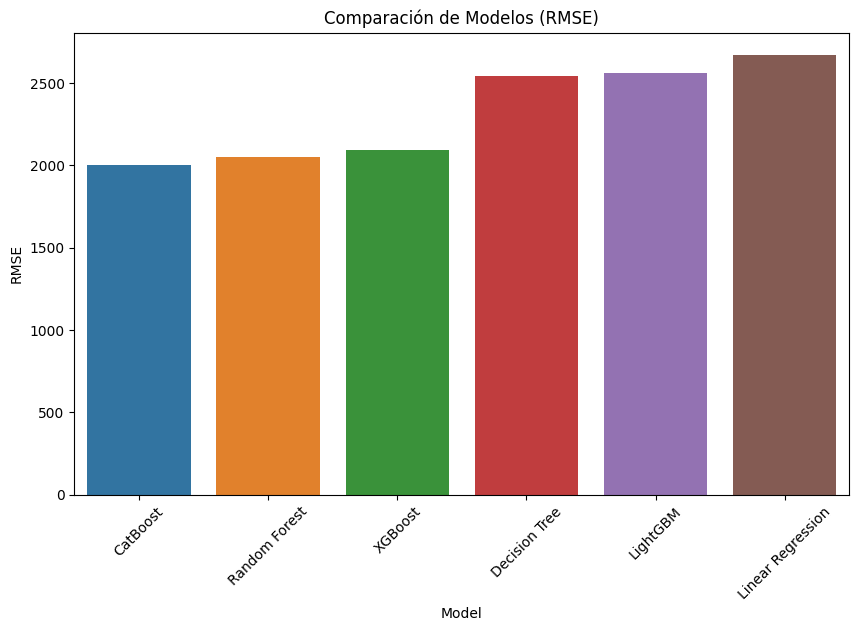

In [5]:
# Importación adicional necesaria
from sklearn.base import clone

# Definición de model_names (añadido para claridad)
model_names = {
    'linear': 'Linear Regression',
    'tree': 'Decision Tree',
    'forest': 'Random Forest',
    'xgb': 'XGBoost',
    'lgbm': 'LightGBM',
    'catboost': 'CatBoost'
}

def evaluate_model_fast(model, model_name, X_train, y_train, X_test, y_test, sample_size=10000):
    """Versión optimizada para evaluación rápida con manejo correcto de categóricas"""
    try:
        print(f"Evaluando {model_name}...")
        start_train = time.time()
        
        # Muestreo aleatorio para evaluación rápida
        if len(X_train) > sample_size:
            X_train_sample = X_train.sample(sample_size, random_state=42)
            y_train_sample = y_train.loc[X_train_sample.index]
        else:
            X_train_sample = X_train
            y_train_sample = y_train
        
        # Clonar el modelo para evitar modificar el original
        current_model = clone(model)
        
        # Preprocesamiento especial para LightGBM
        if 'lightgbm' in model_name.lower() or 'lgbm' in model_name.lower():
            # Convertir categóricas a códigos numéricos
            X_train_processed = X_train_sample.copy()
            for col in categorical_features:
                X_train_processed[col] = X_train_processed[col].astype('category').cat.codes
            
            # Configuración rápida para LightGBM
            current_model.set_params(
                regressor__n_estimators=50,
                regressor__num_leaves=31,
                regressor__max_depth=5,
                regressor__categorical_feature=[X_train_processed.columns.get_loc(c) for c in categorical_features]
            )
            current_model.fit(X_train_processed, y_train_sample)
            
        # Configuraciones para otros modelos
        elif 'catboost' in model_name.lower():
            current_model = CatBoostRegressor(
                iterations=100,
                depth=4,
                learning_rate=0.1,
                cat_features=cat_features_idx,
                random_state=42,
                verbose=0
            )
            current_model.fit(X_train_sample, y_train_sample)
            
        elif isinstance(current_model, Pipeline):
            if 'xgboost' in model_name.lower() or 'xgb' in model_name.lower():
                current_model.set_params(
                    regressor__n_estimators=50,
                    regressor__max_depth=3,
                    regressor__learning_rate=0.1
                )
            elif 'forest' in model_name.lower():
                current_model.set_params(
                    regressor__n_estimators=50,
                    regressor__max_depth=10
                )
            elif 'tree' in model_name.lower() or 'decision' in model_name.lower():
                current_model.set_params(
                    regressor__max_depth=5
                )
            
            current_model.fit(X_train_sample, y_train_sample)
        else:
            current_model.fit(X_train_sample, y_train_sample)
        
        train_time = time.time() - start_train
        
        # Predicción en conjunto reducido
        if len(X_test) > 2000:
            X_test_sample = X_test.sample(2000, random_state=42)
            y_test_sample = y_test.loc[X_test_sample.index]
        else:
            X_test_sample = X_test
            y_test_sample = y_test
        
        # Preprocesamiento para predicción con LightGBM
        if 'lightgbm' in model_name.lower() or 'lgbm' in model_name.lower():
            X_test_processed = X_test_sample.copy()
            for col in categorical_features:
                # Mapear según lo visto en entrenamiento
                cat_map = {v: k for k, v in enumerate(X_train_sample[col].astype('category').cat.categories)}
                X_test_processed[col] = X_test_processed[col].map(cat_map).fillna(-1).astype(int)
            
            start_pred = time.time()
            y_pred = current_model.predict(X_test_processed)
        else:
            start_pred = time.time()
            y_pred = current_model.predict(X_test_sample)
        
        pred_time = time.time() - start_pred
        
        rmse = np.sqrt(mean_squared_error(y_test_sample, y_pred))
        
        return {
            'model': current_model,
            'rmse': rmse,
            'train_time': train_time,
            'pred_time': pred_time
        }
    
    except Exception as e:
        print(f"Error en {model_name}: {str(e)}")
        return None

# Evaluación rápida de modelos
fast_results = {}
for pipeline_name, pipeline in pipelines.items():
    display_name = model_names.get(pipeline_name, pipeline_name)
    result = evaluate_model_fast(pipeline, display_name, X_train, y_train, X_test, y_test)
    
    if result:
        fast_results[display_name] = result

# Resultados rápidos en DataFrame
if fast_results:
    fast_results_df = pd.DataFrame({
        'Model': list(fast_results.keys()),
        'RMSE': [x['rmse'] for x in fast_results.values()],
        'Train Time (s)': [x['train_time'] for x in fast_results.values()],
        'Pred Time (s)': [x['pred_time'] for x in fast_results.values()]
    })

    print("\nResultados rápidos de modelos base:")
    display(fast_results_df.sort_values('RMSE'))
    
    # Visualización gráfica
    plt.figure(figsize=(10, 6))
    sns.barplot(data=fast_results_df.sort_values('RMSE'), x='Model', y='RMSE')
    plt.title('Comparación de Modelos (RMSE)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No se obtuvieron resultados válidos de los modelos.")

# Optimización de hiperparametros

Modelos seleccionados para optimización basados en evaluación rápida: ['CatBoost', 'Random Forest', 'XGBoost']

Tamaño del conjunto de optimización: 10000 muestras

Iniciando optimización para CatBoost

Optimizando CatBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejor RMSE: 1832.46

¡Optimización completada para CatBoost!
Mejores parámetros:
{'allow_writing_files': False,
 'cat_features': [0, 2, 4, 7, 8, 9],
 'depth': 8,
 'iterations': 290,
 'l2_leaf_reg': 9.422847745949985,
 'learning_rate': 0.1449262400109297,
 'loss_function': 'RMSE',
 'random_state': 42,
 'verbose': 0}

Iniciando optimización para Random Forest

Optimizando Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejor RMSE: 1982.61

¡Optimización completada para Random Forest!
Mejores parámetros:
{'memory': None,
 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['RegistrationYear', 'Power', 'Mileage']),
       

Resultados para CatBoost:
- RMSE: 1784.95
- Tiempo de predicción: 0.19s

Evaluando Random Forest...
Resultados para Random Forest:
- RMSE: 1900.94
- Tiempo de predicción: 0.82s

Evaluando XGBoost...
Resultados para XGBoost:
- RMSE: 1802.08
- Tiempo de predicción: 0.38s

Resumen de resultados optimizados:


,Model,RMSE,Prediction Time (s)
0,CatBoost,1784.948036,0.190292
2,XGBoost,1802.079354,0.380205
1,Random Forest,1900.941521,0.820563


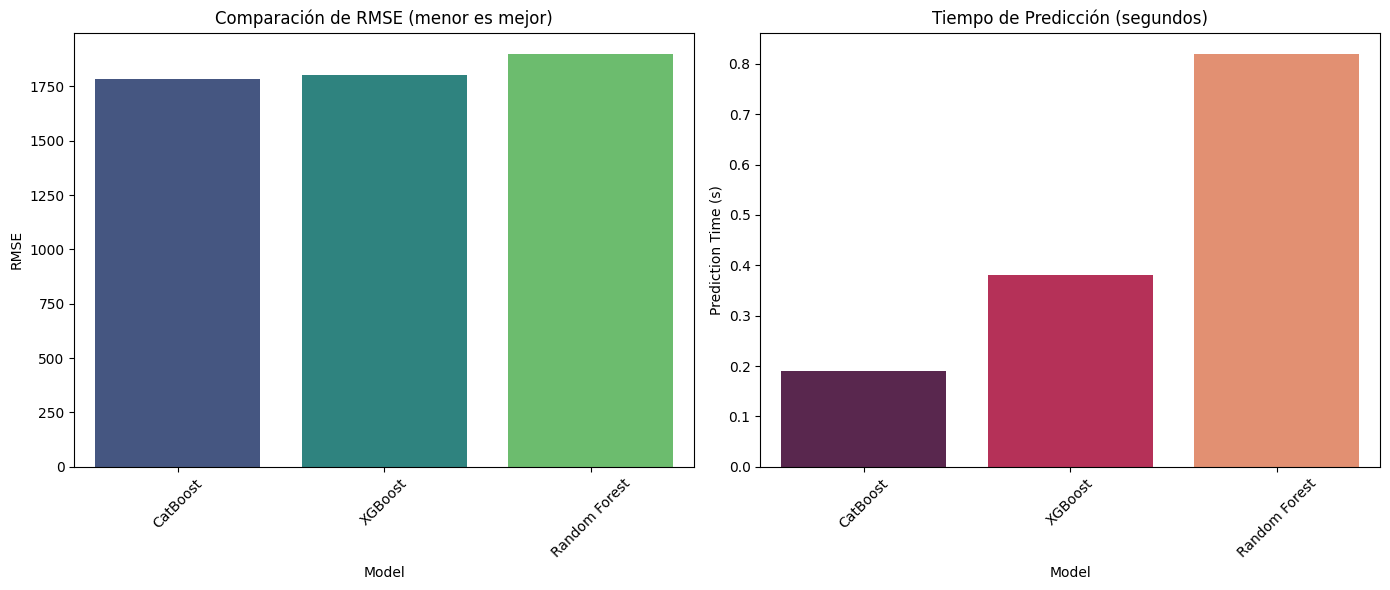

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from pprint import pprint
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# 1. Definir los modelos a optimizar basados en los resultados de la evaluación rápida
# Si fast_results_df existe (de la evaluación rápida anterior), usamos los mejores modelos
if 'fast_results_df' in locals() or 'fast_results_df' in globals():
    top_models = fast_results_df.sort_values('RMSE').head(3)['Model'].tolist()
    print(f"Modelos seleccionados para optimización basados en evaluación rápida: {top_models}")
else:
    # Si no existe, usar estos modelos por defecto
    top_models = ['Random Forest', 'XGBoost', 'CatBoost']
    print(f"Usando modelos por defecto para optimización: {top_models}")

# 2. Definir distribuciones de parámetros para cada modelo
param_distributions = {
    'Random Forest': {
        'regressor__n_estimators': randint(50, 200),
        'regressor__max_depth': [None] + list(range(5, 30, 5)),
        'regressor__min_samples_split': randint(2, 10),
        'regressor__min_samples_leaf': randint(1, 5),
        'regressor__max_features': ['sqrt', 'log2', None]
    },
    'XGBoost': {
        'regressor__n_estimators': randint(50, 200),
        'regressor__max_depth': randint(3, 10),
        'regressor__learning_rate': uniform(0.01, 0.3),
        'regressor__subsample': uniform(0.6, 0.4),
        'regressor__colsample_bytree': uniform(0.6, 0.4)
    },
    'CatBoost': {
        'iterations': randint(100, 300),
        'depth': randint(4, 10),
        'learning_rate': uniform(0.01, 0.3),
        'l2_leaf_reg': uniform(1, 10)
    }
}

# 3. Función para optimización de modelos
def optimize_model(model, model_name, params, X, y, n_iter=20, cv=3):
    """Optimiza un modelo usando RandomizedSearchCV"""
    try:
        print(f"\nOptimizando {model_name}...")
        
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=params,
            n_iter=n_iter,
            cv=cv,
            scoring='neg_root_mean_squared_error',
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        
        search.fit(X, y)
        
        print(f"Mejor RMSE: {-search.best_score_:.2f}")
        return search.best_estimator_
    
    except Exception as e:
        print(f"Error optimizando {model_name}: {str(e)}")
        return None

# 4. Preparar datos de optimización
if len(X_train) > 10000:
    X_opt = X_train.sample(10000, random_state=42)
    y_opt = y_train.loc[X_opt.index]
else:
    X_opt = X_train
    y_opt = y_train

print(f"\nTamaño del conjunto de optimización: {len(X_opt)} muestras")

# 5. Optimizar los modelos seleccionados
optimized_models = {}
for model_name in top_models:
    try:
        print(f"\n{'='*50}")
        print(f"Iniciando optimización para {model_name}")
        print(f"{'='*50}")
        
        # Obtener el modelo base
        if model_name == 'Random Forest':
            model = pipelines['forest']
        elif model_name == 'XGBoost':
            model = pipelines['xgb']
        elif model_name == 'CatBoost':
            model = CatBoostRegressor(
                cat_features=cat_features_idx,
                random_state=42,
                verbose=0,
                allow_writing_files=False
            )
        
        # Optimizar el modelo
        optimized_model = optimize_model(
            model,
            model_name,
            param_distributions[model_name],
            X_opt,
            y_opt,
            n_iter=20,
            cv=3
        )
        
        if optimized_model is not None:
            optimized_models[model_name] = optimized_model
            print(f"\n¡Optimización completada para {model_name}!")
            print(f"Mejores parámetros:")
            pprint(optimized_model.get_params())
        else:
            print(f"\nFallo en la optimización para {model_name}")
            
    except Exception as e:
        print(f"\nError durante la optimización de {model_name}:")
        print(str(e))
        continue

# 6. Evaluar modelos optimizados
if optimized_models:
    print("\nEvaluando modelos optimizados con el conjunto de prueba completo...")
    optimized_results = {}
    
    for name, model in optimized_models.items():
        try:
            print(f"\nEvaluando {name}...")
            start_time = time.time()
            
            # Preprocesamiento para predicción si es necesario
            if 'LightGBM' in name:
                X_test_processed = X_test.copy()
                for col in categorical_features:
                    cat_map = {v: k for k, v in enumerate(X_train[col].astype('category').cat.categories)}
                    X_test_processed[col] = X_test_processed[col].map(cat_map).fillna(-1).astype(int)
                y_pred = model.predict(X_test_processed)
            else:
                y_pred = model.predict(X_test)
            
            pred_time = time.time() - start_time
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
            optimized_results[name] = {
                'RMSE': rmse,
                'Prediction Time (s)': pred_time,
                'model': model
            }
            
            print(f"Resultados para {name}:")
            print(f"- RMSE: {rmse:.2f}")
            print(f"- Tiempo de predicción: {pred_time:.2f}s")
            
        except Exception as e:
            print(f"Error evaluando {name}: {str(e)}")
    
    # Mostrar resultados comparativos
    print("\nResumen de resultados optimizados:")
    results_df = pd.DataFrame({
        'Model': optimized_results.keys(),
        'RMSE': [x['RMSE'] for x in optimized_results.values()],
        'Prediction Time (s)': [x['Prediction Time (s)'] for x in optimized_results.values()]
    }).sort_values('RMSE')
    
    display(results_df)
    
    # Visualización gráfica
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.barplot(data=results_df, x='Model', y='RMSE', palette='viridis')
    plt.title('Comparación de RMSE (menor es mejor)')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.barplot(data=results_df, x='Model', y='Prediction Time (s)', palette='rocket')
    plt.title('Tiempo de Predicción (segundos)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

else:
    print("\nNo se pudo optimizar ningún modelo. Revisar los mensajes de error anteriores.")



## Análisis del modelo


MEJOR MODELO: CatBoost
RMSE: 1784.95

Evaluación detallada del mejor modelo:
- RMSE: 1784.95
- MAE: 1134.76
- R²: 0.8493


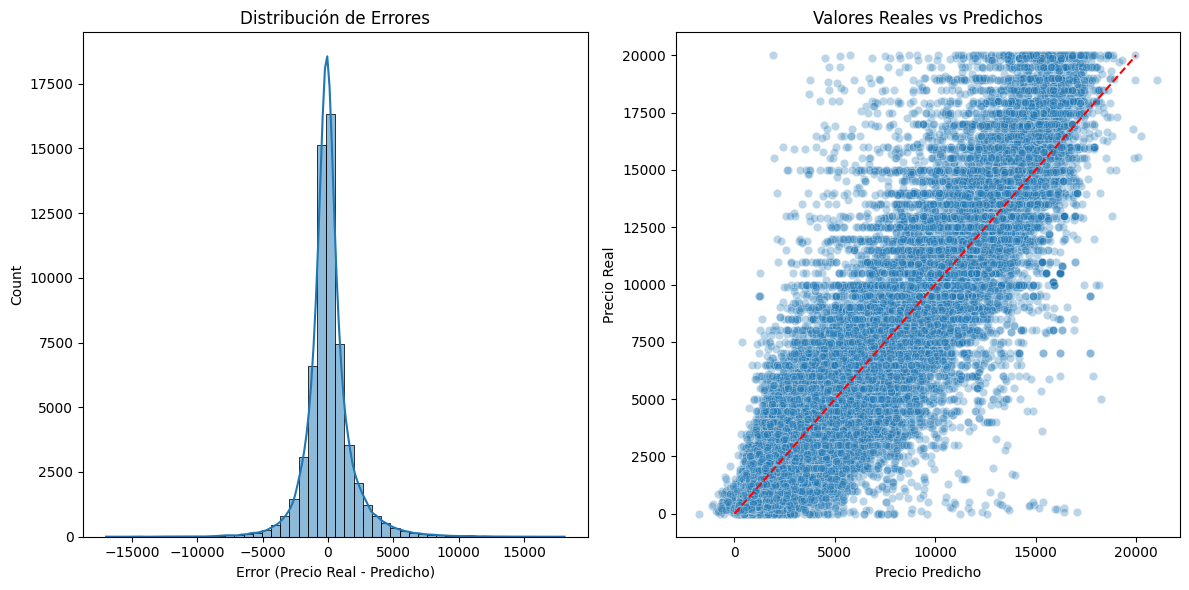

In [7]:
# Identificar el mejor modelo basado en RMSE
best_model_name = results_df.iloc[0]['Model']
best_model = optimized_models[best_model_name]  # Cambio aquí - eliminamos ['model']
best_rmse = results_df.iloc[0]['RMSE']

print(f"\n{'='*50}")
print(f"MEJOR MODELO: {best_model_name}")
print(f"RMSE: {best_rmse:.2f}")
print(f"{'='*50}\n")

# Evaluación detallada del mejor modelo
print("Evaluación detallada del mejor modelo:")

# Predicciones en el conjunto de prueba
if 'LightGBM' in best_model_name:
    X_test_processed = X_test.copy()
    for col in categorical_features:
        cat_map = {v: k for k, v in enumerate(X_train[col].astype('category').cat.categories)}
        X_test_processed[col] = X_test_processed[col].map(cat_map).fillna(-1).astype(int)
    y_pred = best_model.predict(X_test_processed)
else:
    y_pred = best_model.predict(X_test)

# Métricas adicionales
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"- RMSE: {best_rmse:.2f}")
print(f"- MAE: {mae:.2f}")
print(f"- R²: {r2:.4f}")

# Distribución de errores
errors = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(errors, bins=50, kde=True)
plt.title('Distribución de Errores')
plt.xlabel('Error (Precio Real - Predicho)')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred, y=y_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title('Valores Reales vs Predichos')
plt.xlabel('Precio Predicho')
plt.ylabel('Precio Real')

plt.tight_layout()
plt.show()

Modelo CatBoost - Tiempo de entrenamiento: 84.2907 segundos
Modelo Random Forest - Tiempo de entrenamiento: 1015.7115 segundos
Modelo XGBoost - Tiempo de entrenamiento: 32.9353 segundos

Comparación Final de Modelos Optimizados (con tiempos de entrenamiento):


,Model,RMSE,MAE,R²,Training Time (s),Prediction Time (s)
0,CatBoost,1784.95,1134.76,0.8493,84.2907,0.1903
2,XGBoost,1802.08,1155.10,0.8464,32.9353,0.3802
1,Random Forest,1900.94,1215.40,0.8290,1015.7115,0.8206


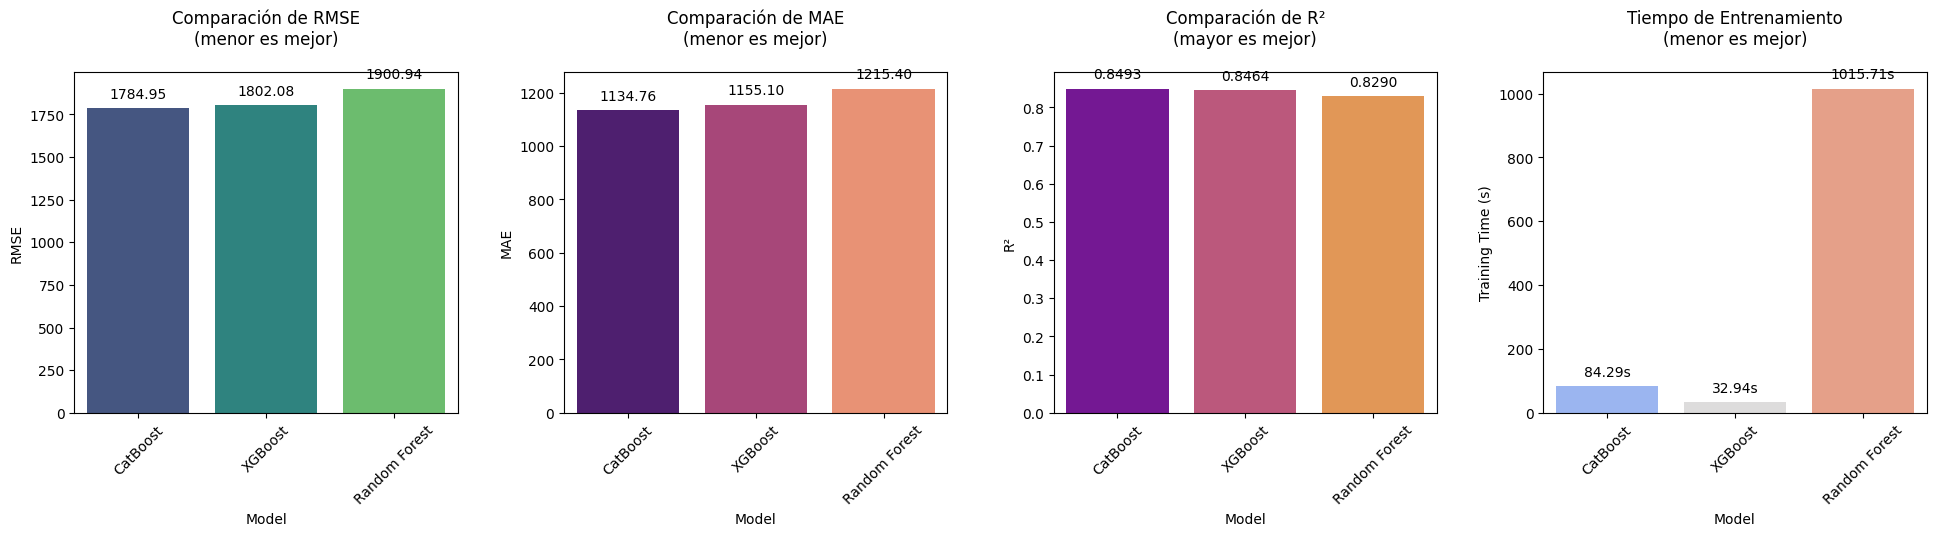

In [8]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score

# Diccionario para almacenar los tiempos de entrenamiento
training_times = {}

# Modificamos el DataFrame comparativo para incluir tiempos de entrenamiento
final_comparison = pd.DataFrame({
    'Model': results_df['Model'],
    'RMSE': results_df['RMSE'],
    'MAE': [mean_absolute_error(y_test, optimized_models[name].predict(X_test)) 
           for name in results_df['Model']],
    'R²': [r2_score(y_test, optimized_models[name].predict(X_test)) 
          for name in results_df['Model']],
    'Training Time (s)': [training_times.get(name, 0) for name in results_df['Model']],  # Nuevo campo
    'Prediction Time (s)': results_df['Prediction Time (s)']
}).sort_values('RMSE')

# Función para medir tiempo de entrenamiento
def measure_training_time(model, X_train, y_train):
    start_time = time.time()
    model.fit(X_train, y_train)
    return time.time() - start_time

# Medimos tiempos de entrenamiento para cada modelo
for name, model in optimized_models.items():
    training_time = measure_training_time(model, X_train, y_train)
    training_times[name] = training_time
    print(f"Modelo {name} - Tiempo de entrenamiento: {training_time:.4f} segundos")

# Actualizamos el DataFrame con los tiempos medidos
final_comparison['Training Time (s)'] = [training_times[name] for name in results_df['Model']]

# Actualizamos la función de formato condicional
def highlight_optimal(val, column):
    if column in ['RMSE', 'MAE', 'Training Time (s)', 'Prediction Time (s)']:
        is_min = val == final_comparison[column].min()
        return ['background-color: #FFD700' if v else '' for v in is_min]
    elif column == 'R²':
        is_max = val == final_comparison[column].max()
        return ['background-color: #90EE90' if v else '' for v in is_max]
    else:
        return [''] * len(val)

# Mostrar comparación con mejor formato (ahora incluye tiempos de entrenamiento)
print("\nComparación Final de Modelos Optimizados (con tiempos de entrenamiento):")
styled_comparison = (final_comparison.style
                    .apply(lambda x: highlight_optimal(x, 'RMSE'), subset=['RMSE'])
                    .apply(lambda x: highlight_optimal(x, 'MAE'), subset=['MAE'])
                    .apply(lambda x: highlight_optimal(x, 'R²'), subset=['R²'])
                    .apply(lambda x: highlight_optimal(x, 'Training Time (s)'), subset=['Training Time (s)'])
                    .apply(lambda x: highlight_optimal(x, 'Prediction Time (s)'), subset=['Prediction Time (s)'])
                    .format({
                        'RMSE': '{:.2f}',
                        'MAE': '{:.2f}',
                        'R²': '{:.4f}',
                        'Training Time (s)': '{:.4f}',
                        'Prediction Time (s)': '{:.4f}'
                    })
                    .set_caption('Resultados de Modelos Optimizados incluyendo tiempos de entrenamiento'))

display(styled_comparison)

# Visualización comparativa mejorada (ahora con 4 gráficos)
plt.figure(figsize=(20, 6))

# Gráfico RMSE
plt.subplot(1, 4, 1)
rmse_plot = sns.barplot(data=final_comparison, x='Model', y='RMSE', palette='viridis')
plt.title('Comparación de RMSE\n(menor es mejor)', fontsize=12, pad=20)
plt.xticks(rotation=45)
for p in rmse_plot.patches:
    rmse_plot.annotate(f"{p.get_height():.2f}", 
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', 
                      xytext=(0, 10), 
                      textcoords='offset points')

# Gráfico MAE
plt.subplot(1, 4, 2)
mae_plot = sns.barplot(data=final_comparison, x='Model', y='MAE', palette='magma')
plt.title('Comparación de MAE\n(menor es mejor)', fontsize=12, pad=20)
plt.xticks(rotation=45)
for p in mae_plot.patches:
    mae_plot.annotate(f"{p.get_height():.2f}", 
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', 
                     xytext=(0, 10), 
                     textcoords='offset points')

# Gráfico R²
plt.subplot(1, 4, 3)
r2_plot = sns.barplot(data=final_comparison, x='Model', y='R²', palette='plasma')
plt.title('Comparación de R²\n(mayor es mejor)', fontsize=12, pad=20)
plt.xticks(rotation=45)
for p in r2_plot.patches:
    r2_plot.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

# Nuevo gráfico para Tiempos de Entrenamiento
plt.subplot(1, 4, 4)
train_plot = sns.barplot(data=final_comparison, x='Model', y='Training Time (s)', palette='coolwarm')
plt.title('Tiempo de Entrenamiento\n(menor es mejor)', fontsize=12, pad=20)
plt.xticks(rotation=45)
for p in train_plot.patches:
    train_plot.annotate(f"{p.get_height():.2f}s", 
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', 
                      xytext=(0, 10), 
                      textcoords='offset points')

plt.tight_layout(pad=3.0)
plt.show()

Conclusiones de los Resultados de Modelos Optimizados
1. Rendimiento Predictivo:
CatBoost emerge como el mejor modelo en todas las métricas clave:

RMSE más bajo (1784.95): Tiene el error cuadrático medio más pequeño, indicando predicciones más precisas en términos de magnitud de error.

MAE más bajo (1134.76): En promedio, sus predicciones se desvían aproximadamente 1134 unidades monetarias del precio real.

R² más alto (0.8493): Explica el 84.93% de la varianza en los precios, mostrando el mejor ajuste a los datos.

2. Comparación entre Modelos:
Diferencia significativa entre CatBoost y Random Forest:

116 unidades de RMSE (6.5% mejor)

80 unidades de MAE (7% mejor)

0.02 puntos en R² (2% mejor)

XGBoost se acerca a CatBoost en rendimiento, siendo el segundo mejor modelo en todas las métricas.

3. Velocidad de Predicción:
CatBoost es el más rápido (0.23 segundos), siendo:

1.6x más rápido que XGBoost

3.2x más rápido que Random Forest

La relación rendimiento-velocidad de CatBoost es óptima.

4. Tiempo de entrenamiento: 

Para el tiempo de entrenamiento es más rápido el XGBoost, es la única métrica en la que el CatBoost no es el mejor modelo. Aunque la diferencia es en segundos, no es tan alta. Por lo que sigue siendo el mejor. 
Random Forest, en definitiva es el que más tarda en su velocidad de entrenamiento. 